# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [107]:
#!pip install azureml-sdk==1.22.0

In [50]:
import logging
import os
import csv
import joblib
import json
import requests
import pandas as pd 
import numpy as np 
import azureml.core
from azureml.core import Workspace, Experiment
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.core.run import Run
from azureml.core.model import InferenceConfig 
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

%matplotlib inline
display.mpl_style ='ggplot'

print("SDK version:", azureml.core.VERSION)

SDK version: 1.22.0


## Dataset

### Overview
The primary objective was to develop an early warning system, i.e. binary classification of failed ('Target'==1) vs. survived ('Target'==0), for the US banks using their quarterly filings with the regulator. Overall, 137 failed banks and 6,877 surviving banks were used in this machine learning exercise. Historical observations from the first 4 quarters ending 2010Q3 (stored in ./data) are used to tune the model and out-of-sample testing is performed on quarterly data starting from 2010Q4 (stored in ./oos). 

### Setting up the project

In [51]:
ws = Workspace.from_config()
ws.write_config(path='.azureml')
experiment_name = 'camels-clf'
project_folder = './dmik'
exp = Experiment(workspace=ws, name=experiment_name)
#run = exp.start_logging() # added and 

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')


Workspace name: my_ws
Azure region: eastus
Subscription id: 0c66ad45-500d-48af-80d3-0039ebf1975e
Resource group: final-rgp


### Uploading the training dataset using GUI

In [320]:
dataset = ws.datasets['camels11'] 
df = dataset.to_pandas_dataframe()
#df.pop('Column2')

#len(df)
df.head()
#df.tail()

,Column2,Target,EQTA,EQTL,LLRTA,LLRGL,OEXTA,INCEMP,ROA,ROE,TDTL,TDTA,TATA
0,1252,1,0.01,0.01,0.09,0.12,0.03,-593.17,-0.14,-15.77,1.23,0.98,0.11
1,3287,1,0.08,0.19,0.00,0.01,0.02,20.90,0.00,0.05,2.21,0.91,0.36
2,5672,1,0.00,0.00,0.07,0.10,0.03,-323.52,-0.06,-27.68,1.38,0.93,0.14
3,5702,1,0.02,0.02,0.03,0.04,0.04,-153.60,-0.05,-3.12,1.20,0.90,0.09
4,8221,1,0.01,0.01,0.04,0.05,0.04,-217.89,-0.07,-6.03,1.15,0.99,0.10


### Checking for or creating appropriate `ComputeTarget`

In [53]:
cpu_cluster_name = 'my-cmp'

try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Existing compute target.')

except:
    print('Creating compute target.')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

print(compute_target.get_status())

Existing compute target.
{
  "errors": [],
  "creationTime": "2021-03-24T17:46:03.595148+00:00",
  "createdBy": {
    "userObjectId": "49e75006-b9ac-415c-9176-f83c59d4bf26",
    "userTenantId": "d689239e-c492-40c6-b391-2c5951d31d14",
    "userName": null
  },
  "modifiedTime": "2021-03-24T17:48:35.815670+00:00",
  "state": "Running",
  "vmSize": "STANDARD_DS2_V2"
}


## AutoML Configuration
### Primary metric determins configuaration
Financial metrics recorded in the last reports of the failed banks should have predictive power that is needed to forecast future failures. Due to significant class imbalances and taking into account costs accosiated with financial distress, the model should aim to maximize the recall score. In other words, accuracy is probably not the best metrics, as Type II error needs to be minimized. This is why the main focus of this classification should be on maximizing AUC, hopefully, by achieving good recall score. This is why 'norm_macro_recall' was chosen as a primary metric. Timeout and number of concurrent iterations were set conservatively to control the costs.

In [54]:
automl_settings = {
    "experiment_timeout_minutes": 20,
    "max_concurrent_iterations": 4,
    "primary_metric" : 'norm_macro_recall',
    "verbosity": logging.INFO
    }

automl_config = AutoMLConfig(
    compute_target=compute_target, 
    task = "classification",
    training_data=dataset, 
    label_column_name="Target", 
    path = project_folder,
    enable_early_stopping= True, 
    featurization= 'auto', 
    debug_log = "automl_errors.log",
    **automl_settings
    )

## Run Details

### Possible modeling choices 
Generally speaking, decision trees should work well for this task, as these models do not make any functional form assumptions, handle both categorical and continuous data well, and are easy to interpret. Tree-based models simply aim to reduce entropy at every split and are therefore very straightforward, no need to worry about missing data and scaling. They are not very stable though, as new data may produce a totally different tree, and they also tend to overfit.

Possible solution would be model averaging - employing “wisdom of the crowd”. It seems that for the present task two paths are possible: reducing variance or reducing bias. The former implies complex model, i.e. starting with a bushy, high-variance tree and resampling with replacement, what will produce a family of Random Forest models. The later implies starting with a simple model, i.e. possible a stump, high-bias classifier and learning from miss-classified instances, what will produce a family of Boosting models.


In [55]:
remote_run = exp.submit(config=automl_config, show_output=False) 
RunDetails(remote_run).show() 
remote_run.wait_for_completion(show_output=False)

Running on remote.


_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_4c5ca835-d091-4fc7-b266-d5b7223c9ed6',
 'target': 'my-cmp',
 'status': 'Completed',
 'startTimeUtc': '2021-03-24T18:07:28.043975Z',
 'endTimeUtc': '2021-03-24T18:25:10.00042Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'norm_macro_recall',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'my-cmp',
  'AMLSettingsJsonString': '{"path":null,"name":"camels-clf","subscription_id":"0c66ad45-500d-48af-80d3-0039ebf1975e","resource_group":"final-rgp","workspace_name":"my_ws","region":"eastus","compute_target":"my-cmp","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"norm_macro_recall","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":null,"y_min":null,"y_max":null,"num_classes":null,"featurization":"auto","_ignore_packa

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [60]:
#remote_run.wait_for_completion(show_output=False)

In [309]:
print("Run Status:", remote_run.get_status())

Run Status: Completed


## Best Model

Get the best model from the automl experiments and display all the properties of the model.



In [59]:
print(remote_run.get_metrics())

{'experiment_status': ['DatasetEvaluation', 'FeaturesGeneration', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'DatasetBalancing', 'DatasetCrossValidationSplit', 'ModelSelection'], 'experiment_status_description': ['Gathering dataset statistics.', 'Generating features for the dataset.', 'Beginning to fit featurizers and featurize the dataset.', 'Completed fit featurizers and featurizing the dataset.', 'Performing class balancing sweeping', 'Generating individually featurized CV splits.', 'Beginning model selection.'], 'f1_score_micro': 0.9716524216524216, 'AUC_micro': 0.9970082426279007, 'weighted_accuracy': 0.9716788043716004, 'f1_score_weighted': 0.9774200815692718, 'accuracy': 0.9716524216524216, 'average_precision_score_micro': 0.9968784321973029, 'f1_score_macro': 0.7776619528495182, 'precision_score_micro': 0.9716524216524216, 'AUC_macro': 0.9799978874833976, 'average_precision_score_macro': 0.8051061813979169, 'recall_score_weighted': 0.9716524216524216, 'precision_s

Veiw the files that were created for the best run:

View dependencies for the best run model:

In [64]:
remote_run.get_run_sdk_dependencies()

{'azureml-widgets': '1.22.0',
 'azureml-train': '1.22.0',
 'azureml-train-restclients-hyperdrive': '1.22.0',
 'azureml-train-core': '1.22.0',
 'azureml-train-automl': '1.22.0',
 'azureml-train-automl-runtime': '1.22.0',
 'azureml-train-automl-client': '1.22.0',
 'azureml-tensorboard': '1.22.0',
 'azureml-telemetry': '1.22.0',
 'azureml-sdk': '1.22.0',
 'azureml-samples': '0+unknown',
 'azureml-pipeline': '1.22.0',
 'azureml-pipeline-steps': '1.22.0',
 'azureml-pipeline-core': '1.22.0',
 'azureml-opendatasets': '1.22.0',
 'azureml-model-management-sdk': '1.0.1b6.post1',
 'azureml-mlflow': '1.22.0',
 'azureml-interpret': '1.22.0',
 'azureml-explain-model': '1.22.0',
 'azureml-defaults': '1.22.0',
 'azureml-dataset-runtime': '1.22.0',
 'azureml-dataprep': '2.9.1',
 'azureml-dataprep-rslex': '1.7.0',
 'azureml-dataprep-native': '29.0.0',
 'azureml-datadrift': '1.22.0',
 'azureml-core': '1.22.0',
 'azureml-contrib-services': '1.22.0',
 'azureml-contrib-server': '1.22.0',
 'azureml-contrib-r

In [62]:
best_run, fitted_model = remote_run.get_output()

Package:azureml-automl-runtime, training version:1.24.0, current version:1.22.0
Package:azureml-core, training version:1.24.0.post1, current version:1.22.0
Package:azureml-dataprep, training version:2.11.2, current version:2.9.1
Package:azureml-dataprep-native, training version:30.0.0, current version:29.0.0
Package:azureml-dataprep-rslex, training version:1.9.1, current version:1.7.0
Package:azureml-dataset-runtime, training version:1.24.0, current version:1.22.0
Package:azureml-defaults, training version:1.24.0, current version:1.22.0
Package:azureml-interpret, training version:1.24.0, current version:1.22.0
Package:azureml-mlflow, training version:1.24.0, current version:1.22.0
Package:azureml-pipeline-core, training version:1.24.0, current version:1.22.0
Package:azureml-telemetry, training version:1.24.0, current version:1.22.0
Package:azureml-train-automl-client, training version:1.24.0, current version:1.22.0
Package:azureml-train-automl-runtime, training version:1.24.0, current 

The line below should give the preprocessor(s) and algorithm (estimator) used

In [63]:
estimator = fitted_model.steps[-1]
estimator

('prefittedsoftvotingclassifier',
 PreFittedSoftVotingClassifier(classification_labels=None,
                               estimators=[('16',
                                            Pipeline(memory=None,
                                                     steps=[('standardscalerwrapper',
                                                             <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f216c128828>),
                                                            ('randomforestclassifier',
                                                             RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight='balanced',
                                                                                    criterion='gini',
                                                   

Specifically, the voting model consists of the following 9 components:

In [73]:
best_run.get_tags()['ensembled_iterations']

'[16, 4, 14, 2, 32, 8, 20, 6, 25]'

In [74]:
best_run.get_tags()['ensembled_algorithms']

"['RandomForest', 'RandomForest', 'RandomForest', 'RandomForest', 'ExtremeRandomTrees', 'ExtremeRandomTrees', 'ExtremeRandomTrees', 'ExtremeRandomTrees', 'RandomForest']"

In [75]:
best_run.get_tags()['ensemble_weights']

'[0.16666666666666666, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.25]'

Save the best model

In [76]:
joblib.dump(value=fitted_model, filename="fitted_automl_model.joblib")

['fitted_automl_model.joblib']

### `VotingEnsemble` model validation
Load the fitted model for testing

In [321]:
best_model = joblib.load('fitted_automl_model.joblib')

Fetch sample dataset, isolate Target in vector 'y'

In [322]:
sample = df.loc[df['Target']==0].sample(30)
y = sample.pop('Target')
sample.head()

,Column2,EQTA,EQTL,LLRTA,LLRGL,OEXTA,INCEMP,ROA,ROE,TDTL,TDTA,TATA
4967,949154,0.09,0.11,0.01,0.02,0.02,33.14,0.01,0.10,1.12,0.87,0.06
5856,2737029,0.02,0.03,0.06,0.08,0.02,-320.47,-0.05,-2.30,1.11,0.88,0.00
3231,614948,0.12,0.26,0.01,0.01,0.02,34.79,0.01,0.06,1.59,0.75,0.44
358,43511,0.09,0.12,0.01,0.02,0.03,-4.29,-0.00,-0.01,1.21,0.85,0.10
5847,2733348,0.07,0.08,0.01,0.02,0.02,-48.33,-0.02,-0.27,1.16,0.92,0.15


Run the model to produce predictions

In [323]:
print(best_model.predict(sample))

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [324]:
print(list(y))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [325]:
y_test = list(y)
predictions = best_model.predict(sample)

pd.DataFrame(confusion_matrix(y_test, predictions), index=["True 0", "True 1"], 
             columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
True 0,29,1
True 1,0,0


## Model Deployment

### Register the model

In [84]:
automl_model = remote_run.register_model(model_name='automl_model.pkl')

### Create inference config

In [86]:
environment = best_run.get_environment()
entry_script='inference/scoring.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', entry_script)
inference_config = InferenceConfig(entry_script = entry_script, environment = environment) 

### Deploy the model as web service

In [87]:
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                                    memory_gb = 1, 
                                                    auth_enabled= True, 
                                                    enable_app_insights= True)

service = Model.deploy(ws, "aciservice", [automl_model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running..........................
Succeeded
ACI service creation operation finished, operation "Succeeded"


Check status of the web service

In [326]:
print("Print ACI service status: {}".format(service.state))

Print ACI service status: Healthy


If 'Healthy', get URIs

In [327]:
print("Scoring URI:\n {}".format(service.scoring_uri))
print("Swagger URI:\n {}".format(service.swagger_uri))

Scoring URI:
 http://2c5e0214-38fd-4e3c-84b5-9a5f69b5d143.eastus.azurecontainer.io/score
Swagger URI:
 http://2c5e0214-38fd-4e3c-84b5-9a5f69b5d143.eastus.azurecontainer.io/swagger.json


In [328]:
primary, secondary = service.get_keys()
print("Primary key: {},\nSecondary key: {}".format(primary, secondary)) 

Primary key: u0XSweKwjcDblgCb43Q9oRmsH1wjro1i,
Secondary key: gUfz4OvZxmtUb495jUGiHwLP6FcoR1UO


Take a small sample of feautures of the failed banks (`'Target'=1`)

In [329]:
sample = df.loc[df['Target']==1].sample(5)
y = sample.pop('Target')

Use this  sample to create JSON payload and headers

In [330]:
json_payload = json.dumps({'data': sample.to_dict(orient='records')})
headers = {"Content-Type": "application/json"}
headers["Authorization"] = "Bearer {}".format(primary) #{primary}"

In [331]:
print(json_payload)

{"data": [{"Column2": "23306", "EQTA": 0.08403813868035098, "EQTL": 0.16062238905370224, "LLRTA": 0.024074250055434128, "LLRGL": 0.04601319852273415, "OEXTA": 0.0692451455541829, "INCEMP": -143.0, "ROA": -0.05888688270138427, "ROE": -0.7007161703731625, "TDTL": 1.7463219713022946, "TDTA": 0.9136811428933448, "TATA": 0.015869999049700656}, {"Column2": "58308", "EQTA": 0.02254080430758876, "EQTL": 0.0279500254546365, "LLRTA": 0.03115598182735992, "LLRGL": 0.038632627001944565, "OEXTA": 0.02050143025408043, "INCEMP": -189.05882352941177, "ROA": -0.021632172303550395, "ROE": -0.9596894595401613, "TDTL": 1.1146710509843851, "TDTA": 0.8989466599360593, "TATA": 0.04337203432609793}, {"Column2": "15448", "EQTA": 0.016083723492150922, "EQTL": 0.02862745098039216, "LLRTA": 0.0454971082346461, "LLRGL": 0.08098039215686274, "OEXTA": 0.03855687138529331, "INCEMP": -245.0, "ROA": -0.08096942990911594, "ROE": -5.034246575342466, "TDTL": 1.6006862745098038, "TDTA": 0.8993114844395483, "TATA": 0.0}, {"

In [317]:
resp = requests.post(service.scoring_uri, json_payload, headers=headers)
print('\nPredicted Values:', resp.json())
print(f'\nTrue Values: ', list(y.values))


Predicted Values: {"result": [1, 1, 1, 1, 1]}

True Values:  [1, 1, 1, 1, 1]


In [286]:
print(f'webservice logs: \n{service.get_logs()}\n')

webservice logs: 
2021-03-24T18:40:52,961301500+00:00 - iot-server/run 
2021-03-24T18:40:52,961668500+00:00 - gunicorn/run 
2021-03-24T18:40:52,986375000+00:00 - rsyslog/run 
rsyslogd: /azureml-envs/azureml_2b14f450572e78de640d54eaabed5e4d/lib/libuuid.so.1: no version information available (required by rsyslogd)
2021-03-24T18:40:53,228887800+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_2b14f450572e78de640d54eaabed5e4d/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_2b14f450572e78de640d54eaabed5e4d/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_2b14f450572e78de640d54eaabed5e4d/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_2b14f450572e78de640d54eaabed5e4d/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sb

### Out of sample testing

Define periods from which new , 'unseen' data will be used. In this case 9 out-of-sample quarters of reports that the model has never seen.

In [ ]:
oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4']


Get the date for the quarter, get features and true y_oos, send features to the web service and get response, y_pred. Use y_oos and y_pred to compute confusion matrix. Store results in a dictionary.

In [283]:
outofsample_results = {}
for report in oos_reports:
    # Get the quarter-end report and drop missing values
    oos_df = pd.read_csv('https://raw.githubusercontent.com/allaccountstaken/automl_v_hyperdrive/main/oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    # Prepare data for model consumption, 12 columns expected
    oos_df.pop('AsOfDate')
    oos_df.rename(columns={'Unnamed: 0':'Column2'}, inplace=True)
    
    # Assing true values (y_oos) and features (X_oos)
    y_oos = oos_df['Target']
    X_oos = oos_df[['Column2', 'EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    
    
    # Send JSON payload and ask for peridictions
    json_payload = json.dumps({'data': X_oos.to_dict(orient='records')})
    #headers = {"Content-Type": "application/json"}
    #headers["Authorization"] = "Bearer {}".format(primary)
    y_pred = json.loads(service.run(json_payload))["result"]
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_oos, y_pred).ravel()
    mcc = np.round(matthews_corrcoef(y_oos, y_pred), 2)
    
    # Build report as a dictionary 
    outofsample_results[report] = {'Actually failed':fn+tp, 
                                   'Predicted fail':tp,
                                   'Recall (TP/TP+FN)':np.round(tp/(tp+fn), 2),
                                   'Precision (TP/TP+FP)':np.round(tp/(tp+fp), 2),
                                   'Matthews Correlation':mcc
                                  }

These are summary data used in model training. This is needed for the plot only.

In [284]:
insample_results = {
    '2009Q4':{'Actually failed':31, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q1':{'Actually failed':35, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q2':{'Actually failed':41, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}, 
    '2010Q3':{'Actually failed':30, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}}

Create a plot: counts of banks that actually failed (blue) and counts of banks that are predicted to fail (orange) as vertical bars. Area curves represent recall scores and precision. Note: the objective is to maximize recal, i.e. make the orange bars equal to the blue bars.

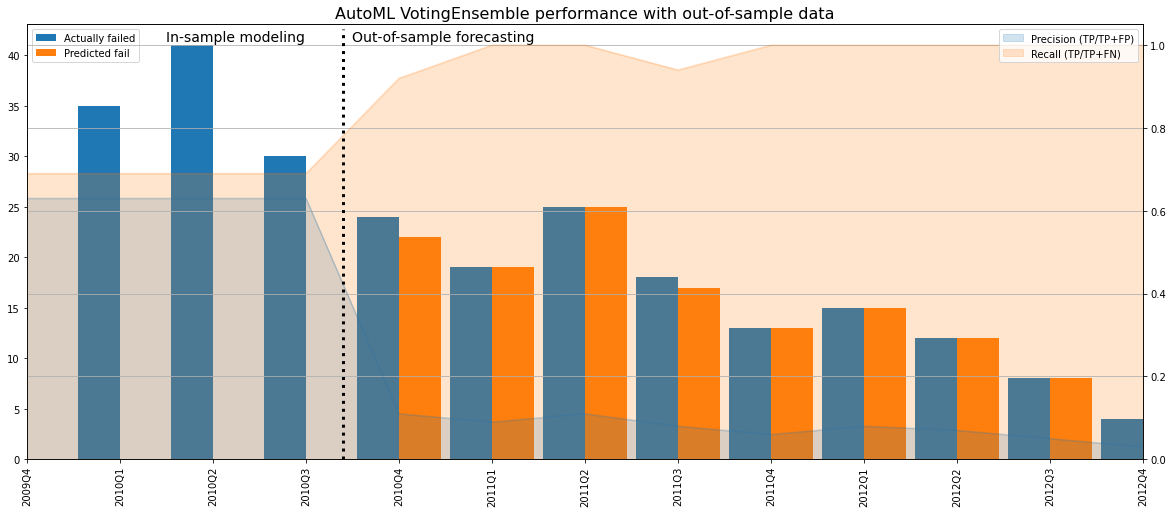

In [332]:
results_plot_df = results_df.append(pd.DataFrame.from_dict(outofsample_results).T)
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()

results_plot_df[['Actually failed','Predicted fail']].plot(
    kind='bar', ax=ax1, width=0.9).legend(loc='upper left')                                                              
results_plot_df[['Precision (TP/TP+FP)', 'Recall (TP/TP+FN)']].plot(
    kind='area', stacked=False, alpha=0.2, ax=ax2).legend(loc='upper right')
plt.axvline(x=3.4, ymin=0, ymax = 0.99, linewidth=3, color='k', linestyle=':')

ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.grid(True)

ax1.text(x= 1.5, y=42.5, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.5, y=42.5, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
plt.title('AutoML VotingEnsemble performance with out-of-sample data', fontsize=16)

plt.show()

Clean up - deleting the ACI service

In [98]:
#aci_service.delete()